# Predicting phases for experimental dataset

In [48]:
# Import packages
%matplotlib inline
import tensorflow as tf
import numpy as np
import os, glob
import gc
import tqdm
import hyperspy.api as hs
from tempfile import TemporaryFile

## Import list of experimental datafile paths to process
If only one file to predict, make it a list `data` of a single path.

In [73]:
# Select which experimental dataset you want to predict.

file_end = 'cropped_sqrt.npz'
#file_end = 'cropped.npz'

tresholded = True #False
base_root = r"D:\jf631\mg24111-1"

data = []
for root, dirs, files in os.walk(base_root):
    for file in files:
        if tresholded:
            if file.endswith(file_end) and 'nonthreshold' not in file:
                data.append(os.path.join(root, file))
        else:
            if file.endswith(file_end) and 'nonthreshold' in file:
                data.append(os.path.join(root, file))
data.sort()
data[:3]

['D:\\jf631\\mg24111-1\\20200927_094445_TripCatBeamDam_3p59A2_150kx_10umAp_20cmCL_scan_array_253x255_diff_plane_515x515_centred_thresholded_radial_norm_cropped_sqrt.npz',
 'D:\\jf631\\mg24111-1\\20200927_101523_TripCatBeamDam_3p59A2_150kx_10umAp_20cmCL_scan_array_254x255_diff_plane_515x515_centred_thresholded_radial_norm_cropped_sqrt.npz',
 'D:\\jf631\\mg24111-1\\20200927_101748_TripCatBeamDam_3p59A2_150kx_10umAp_20cmCL_scan_array_255x255_diff_plane_515x515_centred_thresholded_radial_norm_cropped_sqrt.npz']

## Select a list of models to use to predict
If only one model, make it a list `models` of a single path to the model `.h5` file.

In [74]:
# Select which model to use
cwd = os.path.abspath(os.getcwd())
models = glob.glob(os.path.join(cwd, '*.h5'))
models.sort()
print(len(models))

models

1


['C:\\Users\\Sauron\\Documents\\jf631\\SED_scripts\\nn_models\\20210208_1D_multiclass_corrupted\\NN_4classes_15epochs_2177Train_ac0.9117_2177Test0.9010.h5']

In [76]:
min_y_image_size = 253
date_folder = '20210212'


######### Run the predicting
for model_path in models:

    # Load model
    model = tf.keras.models.load_model(model_path)
    model_basename = os.path.basename(model_path)[:-3]

    if tresholded:
        model_name = model_basename + '_tresholded'
    else:
        model_name = model_basename + '_nontresholded'

    signals = []

    for i, fname in enumerate(tqdm.tqdm(data)):

        exp_npzfile = np.load(fname)
        exp_data = exp_npzfile['exp1d']
        shape = (exp_data.shape[0] *exp_data.shape[1], exp_data.shape[2], 1)
        exp_data_reshape = np.reshape(exp_data, shape)
        exp_preds = model.predict(exp_data_reshape)

        shape = (exp_data.shape[0], exp_data.shape[1], exp_preds.shape[-1])
        exp_pred_reshape = np.reshape(exp_preds, shape)

        exp_pred_reshape = np.moveaxis(exp_pred_reshape, -1, 0)
        s = hs.signals.Signal2D(exp_pred_reshape)

        signals.append(s)

        del exp_npzfile
        del exp_data
        del exp_data_reshape
        del exp_preds
        del exp_pred_reshape
        del s
        gc.collect()

    # Crop and stack
    signals_cropped = [s.isig[:, :min_y_image_size] for s in signals]  ## HARD CODED VALUE!!
    signals = hs.stack(signals_cropped)

    # Add phases in the metadata
    phase_path = model_path[:-3] + '_phases.npy'
    phases = np.load(phase_path)
    phases = [s for s in phases]
    signals.metadata.General.set_item("Phases", phases)

    # Save the stack
    name = model_name + '.hspy'
    print(name)
    signals.save(os.path.join(base_root, 'stacked_predictions', date_folder, name), overwrite=True)

100%|██████████| 76/76 [06:03<00:00,  4.79s/it]


[########################################] | 100% Completed |  0.1s
NN_4classes_15epochs_2177Train_ac0.9117_2177Test0.9010_tresholded.hspy


<Signal2D, title: Stack of , dimensions: (4, 76|255, 253)>


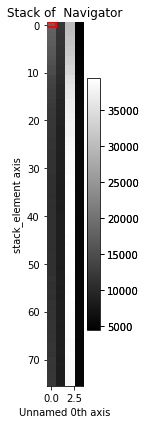

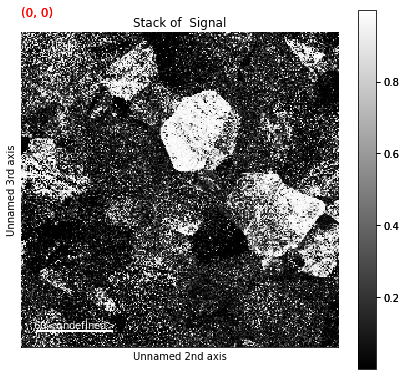

In [77]:
print(signals)
signals.plot()